In [1]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install pillow==4.1.1
%reload_ext autoreload
%autoreload

!pip install hiddenlayer

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-1.0.1-{platform}-linux_x86_64.whl torchvision

    100% |████████████████████████████████| 5.7MB 6.1MB/s 
imgaug 0.2.8 has requirement numpy>=1.15.0, but you'll have numpy 1.14.6 which is incompatible.
albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.8 which is incompatible.
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


    100% |████████████████████████████████| 614.8MB 50.3MB/s 


In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchsummary import summary
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import torch.nn.functional as F
import tempfile
import hiddenlayer as hl
from graphviz import Digraph

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
plt.ion()
input_size=200
momentum = 0.5
log_interval = 10
num_classes=36

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(input_size),
        transforms.RandomResizedCrop(input_size),
        transforms.RandomRotation(30),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}



In [0]:
root_dir = '/content/drive/My Drive/Colab Notebooks/BanglaSignLanguage'
image_datasets = {x: datasets.ImageFolder(os.path.join(root_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

In [9]:
class_names = image_datasets['train'].classes
print(class_names)
print(len(image_datasets['train']))
print(len(image_datasets['val']))

['C', 'D']
723
272


In [0]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.pause(.1)  # pause a bit so that plots are updated


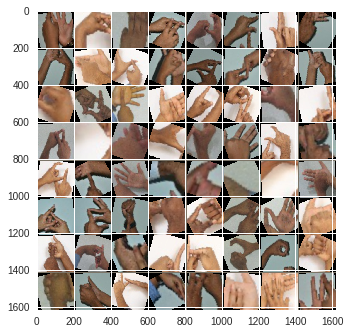

In [11]:
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # Input channels = 3, output channels = 64
        self.conv1 = torch.nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)

        self.conv2 = nn.Sequential(torch.nn.Conv2d(64,64, kernel_size=3, stride=1, padding=1),
                        nn.ReLU(),
                        nn.BatchNorm2d(64,eps=0.001, momentum=0.1, affine=True),
                        torch.nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
                        nn.ReLU(),
                        nn.BatchNorm2d(64)
                                   )

        self.conv3 = nn.Sequential(torch.nn.Conv2d(64,64, kernel_size=3, stride=2, padding=1),
                        nn.ReLU(),
                        nn.BatchNorm2d(64,eps=0.001, momentum=0.1, affine=True))

        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # 256 input features, 64 output features
        self.fc1 = torch.nn.Linear(256, 64)
        self.fc2 = torch.nn.Linear(64, 32)
        self.fc3 = torch.nn.Linear(32, 36)
        self.drop = nn.Dropout(p=0.6)

    def forward(self, x):
        # Computes the activation of the first convolution

        x = self.conv1(x)
        #print(x.shape)
        x = self.conv2(x)
        #print(x.shape)
        x = self.conv3(x)              # Size changes from (64, 25, 25) to (64, 12, 12)
        #print(x.shape)
        x = self.conv2(x)
        #print(x.shape)
        x = self.conv3(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv2(x)
        #x = self.conv3(x)
        #print(x.shape)

        # Reshape data to input to the input layer of the neural net
        # Recall that the -1 infers this dimension from the other given dimension
        x = x.view(-1, 256)
        # print(x.shape)

        # Computes the activation of the first fully connected layer
        # Size changes from (1, 4608) to (1, 64)
        x=self.drop(x)
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        x = F.relu(self.fc2(x))
        x = self.drop(x)
        x = F.relu(self.fc3(x))
        return (x)

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [0]:
def visualize_model(model, num_images=20):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 200, 200]           1,792
            Conv2d-2         [-1, 64, 200, 200]          36,928
              ReLU-3         [-1, 64, 200, 200]               0
       BatchNorm2d-4         [-1, 64, 200, 200]             128
            Conv2d-5         [-1, 64, 100, 100]          36,928
              ReLU-6         [-1, 64, 100, 100]               0
       BatchNorm2d-7         [-1, 64, 100, 100]             128
            Conv2d-8           [-1, 64, 50, 50]          36,928
              ReLU-9           [-1, 64, 50, 50]               0
      BatchNorm2d-10           [-1, 64, 50, 50]             128
           Conv2d-11           [-1, 64, 50, 50]          36,928
             ReLU-12           [-1, 64, 50, 50]               0
      BatchNorm2d-13           [-1, 64, 50, 50]             128
           Conv2d-14           [-1, 64,

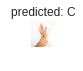

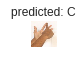

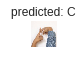

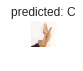

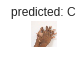

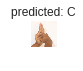

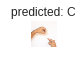

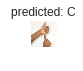

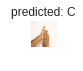

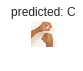

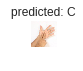

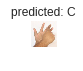

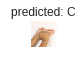

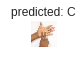

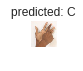

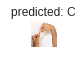

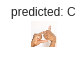

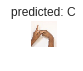

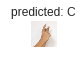

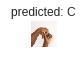

In [15]:
model = Net()
hl.build_graph(model, torch.zeros([1, 3, input_size,input_size]))
model = model.to(device)

summary(model,(3,input_size,input_size))
criterion = nn.CrossEntropyLoss()
optimizer_net = optim.Adam(model.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_net, step_size=7, gamma=0.1)

model = train_model(model, criterion, optimizer_net, exp_lr_scheduler, num_epochs=20)

visualize_model(model)
plt.ioff()
plt.show()

In [0]:
confusion_matrix = torch.zeros(num_classes, num_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['val']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
